In [1]:
from keras.datasets import mnist
from keras.layers import *
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential,Model
from tensorflow import keras
import matplotlib.pyplot as plt
import math
import numpy as np

Using TensorFlow backend.


In [2]:
(X_Train,_),(_,_) = mnist.load_data()  

11493376/11490434 [==============================] - 1s 0us/step


In [3]:
print(X_Train.shape)
print(type(X_Train))

X_Train = X_Train.reshape((*(X_Train.shape),1))
print(X_Train.shape)

(60000, 28, 28)
<class 'numpy.ndarray'>
(60000, 28, 28, 1)


In [4]:
#Normalize the Data between -1 and 1

X_Train = (X_Train.astype('float32') - 127.5)/127.5

print(np.min(X_Train))
print(np.max(X_Train))

-1.0
1.0


In [5]:
NUM_EPOCHS = 50
BATCH_SIZE = 256
NO_OF_BATCHES = math.ceil(X_Train.shape[0]/float(BATCH_SIZE))
HALF_BATCH_SIZE = int(BATCH_SIZE/2)

NOISE_DIM = 100

adam = keras.optimizers.Adam(learning_rate=2e-4,beta_1=0.5)

In [6]:
#Upsampling 
# Start from 7 X 7 X 128
generator = Sequential()
generator.add(Dense(7*7*128,input_shape=(NOISE_DIM,)))
generator.add(Reshape((7,7,128)))
generator.add(LeakyReLU(0.2))
generator.add(BatchNormalization())

#Double the Activation Size 14 X 14 X 64
generator.add(UpSampling2D())
generator.add(Conv2D(64,kernel_size=(5,5),padding='same'))
generator.add(LeakyReLU(0.2))
generator.add(BatchNormalization())

# Double the Activation Size 28 X 28 X 1
generator.add(UpSampling2D())
generator.add(Conv2D(1, kernel_size=(5, 5), padding='same', activation='tanh'))

# Final Output (No ReLu or Batch Norm)
generator.compile(loss='binary_crossentropy', optimizer=adam)
generator.summary()



#Discriminator - Downsampling
discriminator = Sequential()
discriminator.add(Conv2D(64,(5,5),strides=(2,2),padding='same',input_shape=(28,28,1)))
discriminator.add(LeakyReLU(0.2))

# Prefer Strided Convolutions over MaxPooling
discriminator.add(Conv2D(128,(5,5),strides=(2,2),padding='same'))
discriminator.add(LeakyReLU(0.2))


discriminator.add(Flatten())
discriminator.add(Dense(1,activation='sigmoid'))

discriminator.compile(loss='binary_crossentropy',optimizer=adam)
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6272)              633472    
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        204864    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 14, 14, 64)       

In [7]:
discriminator.trainable = False
gan_input = Input(shape=(NOISE_DIM,))
generated_img = generator(gan_input)
gan_output = discriminator(generated_img)

#Functional API
model = Model(gan_input,gan_output)
model.compile(loss='binary_crossentropy',optimizer=adam)

def save_imgs(epoch,samples=100):
    noise = np.random.normal(0,1,size=(samples,NOISE_DIM))
    generated_imgs = generator.predict(noise)
    generated_imgs = generated_imgs.reshape(samples,28,28)
    
    plt.figure(figsize=(10,10))
    for i in range(samples):
        plt.subplot(10,10,i+1)
        plt.imshow(generated_imgs[i],interpolation='nearest',cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('/content/images/gan_output_epoch_{0}.png'.format(epoch+1))
    plt.show()
  


In [9]:
!mkdir models

In [10]:
X_Train.shape

(60000, 28, 28, 1)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch 1 D loss: 126.839242 G loss: 145.649521
Epoch 2 D loss: 178.251403 G loss: 202.494304
Epoch 3 D loss: 164.266964 G loss: 210.106807
Epoch 4 D loss: 163.244443 G loss: 202.845223
Epoch 5 D loss: 165.187505 G loss: 194.605865
Epoch 6 D loss: 164.382367 G loss: 193.783620
Epoch 7 D loss: 163.560980 G loss: 193.404597
Epoch 8 D loss: 163.081380 G loss: 193.237077
Epoch 9 D loss: 162.574020 G loss: 195.076118
Epoch 10 D loss: 162.364984 G loss: 193.867227


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


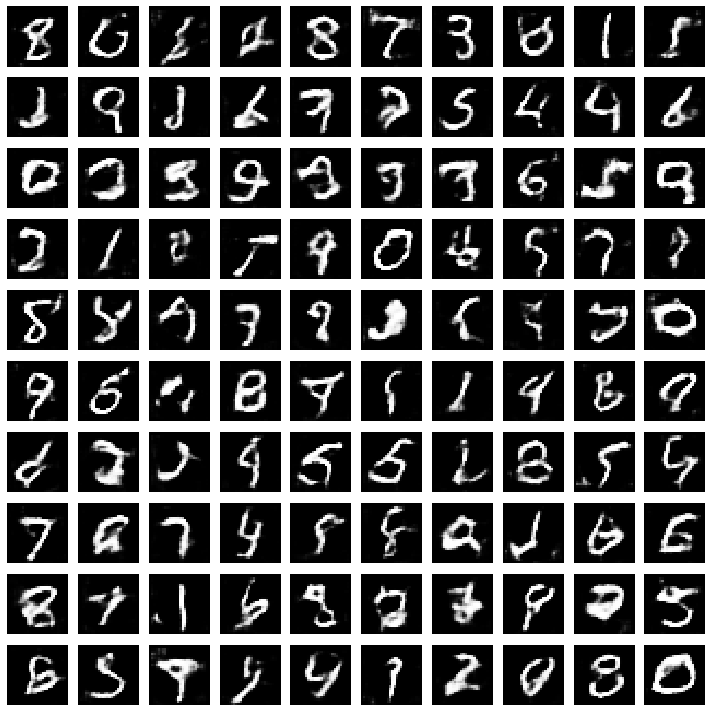

Epoch 11 D loss: 162.131679 G loss: 194.159613
Epoch 12 D loss: 161.889768 G loss: 194.869464
Epoch 13 D loss: 161.671338 G loss: 194.779828
Epoch 14 D loss: 161.554392 G loss: 194.973456
Epoch 15 D loss: 161.369574 G loss: 195.219106
Epoch 16 D loss: 161.295454 G loss: 195.094919
Epoch 17 D loss: 161.136404 G loss: 195.351616
Epoch 18 D loss: 161.203218 G loss: 194.778144
Epoch 19 D loss: 160.873914 G loss: 198.298817
Epoch 20 D loss: 160.827878 G loss: 196.258515


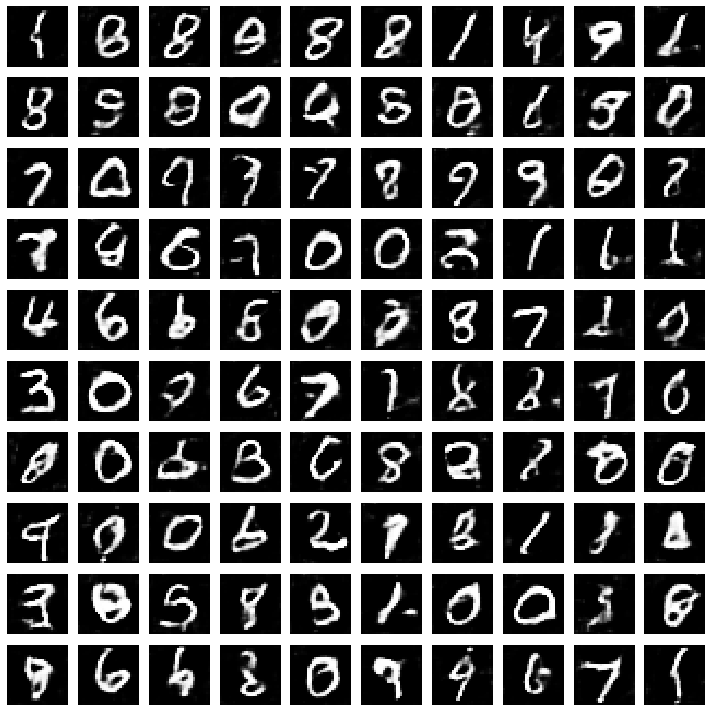

Epoch 21 D loss: 160.660404 G loss: 198.446965
Epoch 22 D loss: 160.535330 G loss: 196.834567
Epoch 23 D loss: 160.563412 G loss: 196.183210
Epoch 24 D loss: 160.454669 G loss: 196.768503
Epoch 25 D loss: 160.081246 G loss: 201.633368
Epoch 26 D loss: 159.691151 G loss: 201.274083
Epoch 27 D loss: 159.995593 G loss: 198.283108
Epoch 28 D loss: 159.883442 G loss: 198.936015
Epoch 29 D loss: 159.741400 G loss: 199.999204
Epoch 30 D loss: 159.646882 G loss: 200.742306


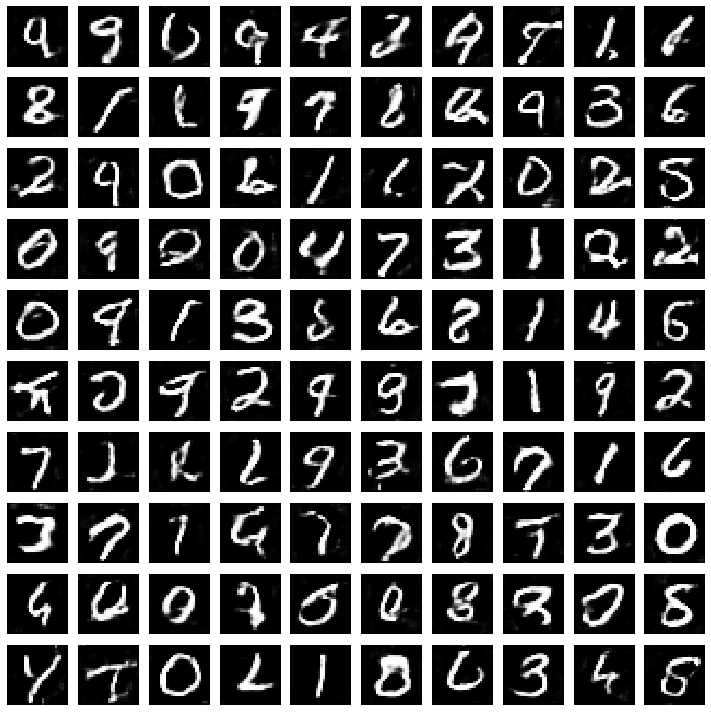

Epoch 31 D loss: 159.387729 G loss: 201.317272
Epoch 32 D loss: 158.548060 G loss: 209.615781
Epoch 33 D loss: 158.964979 G loss: 202.001186
Epoch 34 D loss: 158.827554 G loss: 202.914081
Epoch 35 D loss: 158.717266 G loss: 204.134250
Epoch 36 D loss: 158.530443 G loss: 204.924480
Epoch 37 D loss: 158.285162 G loss: 206.263626
Epoch 38 D loss: 158.193234 G loss: 206.851962
Epoch 39 D loss: 157.931065 G loss: 207.658873
Epoch 40 D loss: 157.516858 G loss: 209.697798


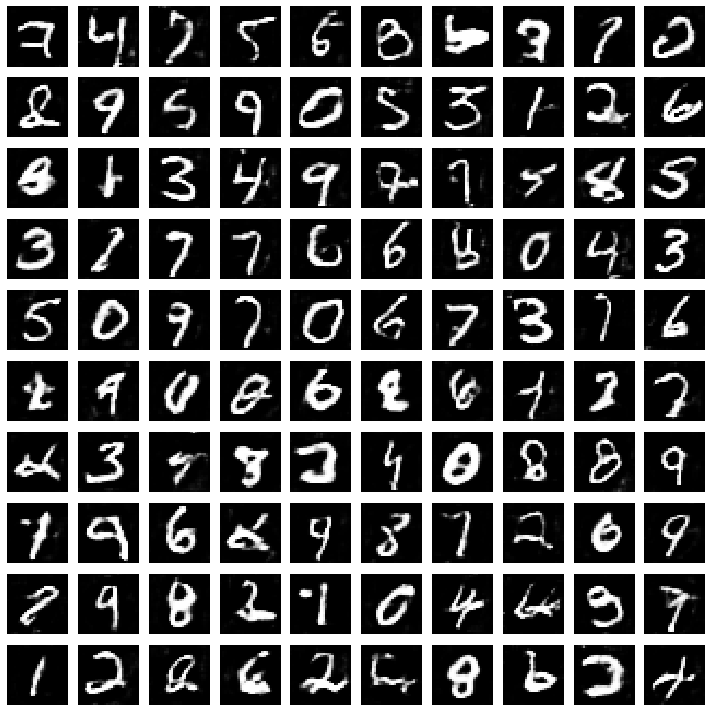

Epoch 41 D loss: 157.434399 G loss: 210.644315
Epoch 42 D loss: 157.184379 G loss: 210.357634
Epoch 43 D loss: 156.914554 G loss: 212.841451
Epoch 44 D loss: 156.875668 G loss: 212.095228
Epoch 45 D loss: 156.497809 G loss: 213.229187
Epoch 46 D loss: 156.353755 G loss: 214.835580
Epoch 47 D loss: 155.749498 G loss: 215.847951
Epoch 48 D loss: 155.620752 G loss: 217.929139
Epoch 49 D loss: 155.417144 G loss: 217.706313
Epoch 50 D loss: 155.238830 G loss: 218.702850


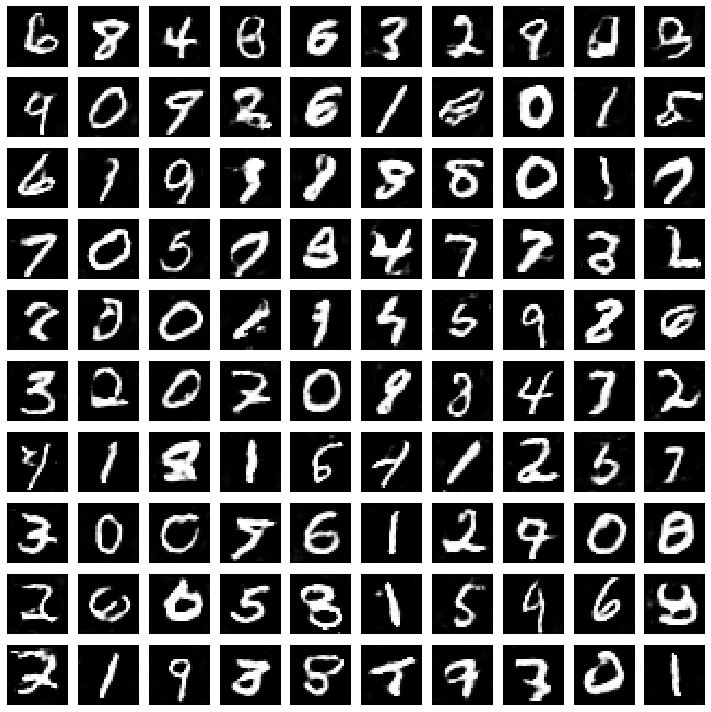

In [11]:
for epoch in range(NUM_EPOCHS):
    epoch_d_loss = 0.
    epoch_g_loss = 0.
    
    for step in range(NO_OF_BATCHES):
        #randomly select 50% real images
        idx = np.random.randint(0,X_Train.shape[0],HALF_BATCH_SIZE)
        real_imgs = X_Train[idx]
        
        # generate 50% random images
        noise = np.random.normal(0,1,size=(HALF_BATCH_SIZE,NOISE_DIM))
        fake_imgs = generator.predict(noise)
        
        
        # one sided label smoothing
        real_y = np.ones((HALF_BATCH_SIZE,1))*0.9 #Label Smoothing, Works well in practice
        fake_y = np.zeros((HALF_BATCH_SIZE,1))
        
        # train on real and fake images
        d_loss_real = discriminator.train_on_batch(real_imgs,real_y) #updates the weights of discriminator
        d_loss_fake = discriminator.train_on_batch(fake_imgs,fake_y) 
        d_loss = 0.5*d_loss_real + 0.5*d_loss_fake
        
        epoch_d_loss += d_loss
        
        
        #Train Generator (Complete Model Generator + Frozen Discriminator)
        
        noise = np.random.normal(0,1,size=(BATCH_SIZE,NOISE_DIM))
        real_y = np.ones((BATCH_SIZE,1))
        g_loss = model.train_on_batch(noise,real_y)
        epoch_g_loss += g_loss
        
    print("Epoch %d D loss: %f G loss: %f" % ((epoch + 1), epoch_d_loss, epoch_g_loss))

    if (epoch+1)%10==0:
        generator.save('/content/models/gan_generator_{0}.h5'.format(epoch+1))
        save_imgs(epoch)